In [5]:
pip install numpy --upgrade

ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'C:\\Users\\sabim\\Anaconda3\\Lib\\site-packages\\~umpy\\.libs\\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.



  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5


In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [1]:
conda list

# packages in environment at C:\Users\sabim\Anaconda3:
#
# Name                    Version                   Build  Channel
_ipyw_jlab_nb_ext_conf    0.1.0                    py38_0  
absl-py                   1.2.0                    pypi_0    pypi
aiohttp                   3.8.1                    pypi_0    pypi
aiosignal                 1.2.0                    pypi_0    pypi
alabaster                 0.7.12                     py_0  

Note: you may need to restart the kernel to use updated packages.
anaconda                  2020.07                  py38_0  
anaconda-client           1.7.2                    py38_0  
anaconda-navigator        1.9.12                   py38_0  
anaconda-project          0.8.4                      py_0  
argh                      0.26.2                   py38_0  
asn1crypto                1.3.0                    py38_0  
astroid                   2.4.2                    py38_0  
astropy                   4.0.1.post1      py38he774522_1  
astunparse 

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv("train.csv")
df.head(5)

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [6]:
df.groupby('target').describe()

qid                                     question_text           \
          count   unique                   top freq         count   unique   
target                                                                       
0       1225312  1225312  124c075166db8af1691d    1       1225312  1225312   
1         80810    80810  1b541e75e6d4900691dd    1         80810    80810   

                                                       
                                             top freq  
target                                                 
0       Can we drink milk with banana after gym?    1  
1                       Are Indian girls boring?    1

In [7]:
df['target'].value_counts()

0    1225312
1      80810
Name: target, dtype: int64

In [8]:
80810/1225312

0.06595054973753624

6% insincere ques, 94% sincere ques: This indicates class imbalance

In [10]:
df_spam = df[df['target']==1]
df_spam.shape

(80810, 3)

In [11]:
df_ham = df[df['target']==0]
df_ham.shape

(1225312, 3)

In [12]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(80810, 3)

In [13]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(161620, 3)

In [14]:
df_balanced['target'].value_counts()

1    80810
0    80810
Name: target, dtype: int64

In [18]:
df_balanced_1=df_balanced

In [19]:
df_balanced_1.drop("qid",axis=1, inplace=True)

In [21]:
df_balanced_1.shape

(161620, 2)

In [22]:
df_balanced_copy= df_balanced

In [23]:
df_balanced = df_balanced_1

In [24]:
df_balanced['target'].value_counts()

1    80810
0    80810
Name: target, dtype: int64

In [27]:
df_balanced.head()

,question_text,target
356503,I wanted to start a relationship with any girl...,0
316399,How can I recover deleted not files on my iPod 6?,0
1163530,Can I go in LPU Btech programe through NIOS bo...,0
863842,What if anti-racial-supremacists hating the KK...,0
436503,What do you feel about Quora now displaying li...,0


In [28]:
df_balanced[df_balanced['target']==1].head()

,question_text,target
22,Has the United States become the largest dicta...,1
30,Which babies are more sweeter to their parents...,1
110,If blacks support school choice and mandatory ...,1
114,I am gay boy and I love my cousin (boy). He is...,1
115,Which races have the smallest penis?,1


#### Split it into training and test data set

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['question_text'],df_balanced['target'], stratify=df_balanced['target'])

In [30]:
X_train.head(4)

1154267    What ate some techniques implemented in snake ...
691161     What would have happened if in April 1945 USA ...
134257     What are some unconventional approaches you’re...
89276      Why do Indians and Bangladeshis refer to Pakis...
Name: question_text, dtype: object

#### Now lets import BERT model and get embedding vectors for few sample statements

In [31]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

#### Build Model
There are two types of models you can build in tensorflow.

(1) Sequential (2) Functional

However, for our research we will build functional model. 

In [32]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [33]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [34]:
len(X_train)

121215

In [35]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

#### Train the model

In [37]:
model.fit(X_train, y_train, epochs=2)

Epoch 1/2
3788/3788 [==============================] - 30289s 8s/step - loss: 0.4612 - accuracy: 0.7925 - precision: 0.8011 - recall: 0.7782
Epoch 2/2
3788/3788 [==============================] - 27856s 7s/step - loss: 0.4047 - accuracy: 0.8233 - precision: 0.8259 - recall: 0.8194


In [39]:
model.evaluate(X_test, y_test)

1263/1263 [==============================] - 9528s 8s/step - loss: 0.3639 - accuracy: 0.8465 - precision: 0.8594 - recall: 0.8286


[0.3638618290424347,
 0.8465288877487183,
 0.8594311475753784,
 0.8285897970199585]

In [40]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

1263/1263 [==============================] - 11045s 9s/step


In [41]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 0, 1, ..., 1, 1, 1])

In [42]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[17464,  2738],
       [ 3463, 16740]], dtype=int64)

Text(33.0, 0.5, 'Truth')

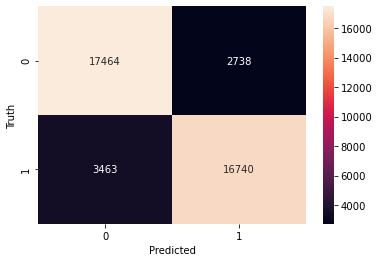

In [43]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [44]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.83      0.86      0.85     20202
           1       0.86      0.83      0.84     20203

    accuracy                           0.85     40405
   macro avg       0.85      0.85      0.85     40405
weighted avg       0.85      0.85      0.85     40405



In [45]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 3s 3s/step


array([[0.19342263],
       [0.0302413 ],
       [0.05887423],
       [0.05804042],
       [0.21732703]], dtype=float32)

In [47]:
model.save('bert_model_with_neural_network')

INFO:tensorflow:Assets written to: bert_model_with_neural_network\assets


INFO:tensorflow:Assets written to: bert_model_with_neural_network\assets
